In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import bottleneck as bn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nxa
import igraph as ig
# http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn import decomposition
%matplotlib inline

import missingno as msno
from collections import defaultdict, Counter

from IPython.display import display

from speclib.loaders import (loadUserPhonenumberDict, getUserList, Useralias, loadUser2,
                             loadUserParallel, dict2DataFrame, users2DataFrame)
from speclib.plotting import looseAxesLimits, barSBS, countsOnBarPlot, plotNeatoGraph
from speclib.graph import networkx2igraph, igraph2networkx


%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno,networkx,igraph

Allan Leander Rostock Hansen 
last updated: 2017-02-13 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
bottleneck 1.2.0
pandas 0.19.1
matplotlib 2.0.0rc2
sklearn 0.18.1
missingno n
networkx 1.11
igraph 0.7.1


In [2]:
ua = Useralias()
userList = getUserList()
userSpec = [(user, ua[user], ('sms', 'call')) for user in userList[:10]]
userData = loadUserParallel(userSpec) 
df = users2DataFrame(userData, ua)
del userData
phonebook = loadUserPhonenumberDict(ua) 

In [3]:
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

In [4]:
df.shape

(58622, 7)

In [5]:
df = df[df.number.apply(lambda num: num in phonebook)] 
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN       0.0     1  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       0.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN      29.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   
      call     NaN      22.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       3.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1390698006 2014-01-26 01:00:06        6  
      call     1391176805 2014-01-31 14:00:05        4  
      call     1391782631 2014-02-07 14:17:11        4  
      call     1391782712 2014-02-07 14:18:32        4  
      call     1394805935 2014-03-14 14:05:35        4

In [6]:
df.shape

(2557, 7)

In [7]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x])
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN       0.0     1  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       0.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN      29.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   
      call     NaN      22.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       3.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   

                  timeint           timestamp  weekday contactedUser  
user  comtype                                                         
u0001 call     1390698006 2014-01-26 01:00:06        6         u0468  
      call     1391176805 2014-01-31 14:00:05        4         u0468  
      call     1391782631 2014-02-07 14:17:11        4         u0551  
      call     1391782712 2014-02-07 14:18:32        4         u0468  
      call     1394805935 2014-03-14 14:05:35        4         u0551

In [8]:
try:
    df.drop(['duration', 'hour', 'number', 'timeint', 'weekday'], axis=1, inplace=True) 
except ValueError:
    pass
df.head() 

body           timestamp contactedUser
user  comtype                                       
u0001 call     NaN 2014-01-26 01:00:06         u0468
      call     NaN 2014-01-31 14:00:05         u0468
      call     NaN 2014-02-07 14:17:11         u0551
      call     NaN 2014-02-07 14:18:32         u0468
      call     NaN 2014-03-14 14:05:35         u0551

In [9]:
uniqueUsers = set(df.index.get_level_values('user').unique()) 
uniqueUsers

{'u0001',
 'u0002',
 'u0003',
 'u0004',
 'u0005',
 'u0006',
 'u0007',
 'u0008',
 'u0009',
 'u0010'}

In [10]:
for user in uniqueUsers:
    contactable = list(uniqueUsers - {user})
    nContacted = len(df.loc[user].contactedUser)
    df.loc[user, 'contactedUser'] = np.random.choice(contactable, size=nContacted)

df.head() 

body           timestamp contactedUser
user  comtype                                       
u0001 call     NaN 2014-01-26 01:00:06         u0006
      call     NaN 2014-01-31 14:00:05         u0009
      call     NaN 2014-02-07 14:17:11         u0006
      call     NaN 2014-02-07 14:18:32         u0010
      call     NaN 2014-03-14 14:05:35         u0004

In [11]:
dfs = df.sample(n=25)
# dfs = dfs.reset_index()
# dfs.drop('comtype', axis=1, inplace=True)
# dfs = dfs.set_index('user')
# dfs.sort_index(inplace=True)
# dfs.head(10) 

In [12]:
dct = dict()
for user in dfs.index.get_level_values('user').unique():
    dct[user] = dfs.loc[user].contactedUser.unique().tolist() 
dct

{'u0002': ['u0007', 'u0005'],
 'u0004': ['u0003', 'u0006', 'u0005', 'u0008'],
 'u0005': ['u0007', 'u0008', 'u0003', 'u0006'],
 'u0007': ['u0008', 'u0009', 'u0006', 'u0010', 'u0001', 'u0003', 'u0005'],
 'u0008': ['u0006', 'u0001', 'u0004'],
 'u0010': ['u0007', 'u0003']}

In [13]:
dfa = pd.DataFrame(columns=('contacted',))
for user in dfs.index.get_level_values('user').unique():
    dfa.loc[user, 'contacted'] = dfs.loc[user].contactedUser.unique().tolist() 

In [14]:
dfa

,contacted
u0008,"[u0006, u0001, u0004]"
u0004,"[u0003, u0006, u0005, u0008]"
u0007,"[u0008, u0009, u0006, u0010, u0001, u0003, u0005]"
u0005,"[u0007, u0008, u0003, u0006]"
u0010,"[u0007, u0003]"
u0002,"[u0007, u0005]"


In [15]:
dfa = pd.DataFrame(columns=sorted(uniqueUsers), index=sorted(uniqueUsers))
for user in dfs.index.get_level_values('user').unique():
    for com in dfs.loc[user].contactedUser.unique().tolist():
        dfa.loc[user, com] = 1
dfa

,u0001,u0002,u0003,u0004,u0005,u0006,u0007,u0008,u0009,u0010
u0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0002,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN
u0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0004,NaN,NaN,1,NaN,1,1,NaN,1,NaN,NaN
u0005,NaN,NaN,1,NaN,NaN,1,1,1,NaN,NaN
u0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0007,1,NaN,1,NaN,1,1,NaN,1,1,1
u0008,1,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN
u0009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0010,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN


In [16]:
dfa = pd.DataFrame(columns=sorted(uniqueUsers), index=sorted(uniqueUsers))
for user in dfs.index.get_level_values('user').unique():
    dfa.loc[user, dfs.loc[user].contactedUser.unique().tolist()] = 1
dfa

,u0001,u0002,u0003,u0004,u0005,u0006,u0007,u0008,u0009,u0010
u0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0002,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN
u0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0004,NaN,NaN,1,NaN,1,1,NaN,1,NaN,NaN
u0005,NaN,NaN,1,NaN,NaN,1,1,1,NaN,NaN
u0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0007,1,NaN,1,NaN,1,1,NaN,1,1,1
u0008,1,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN
u0009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0010,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN


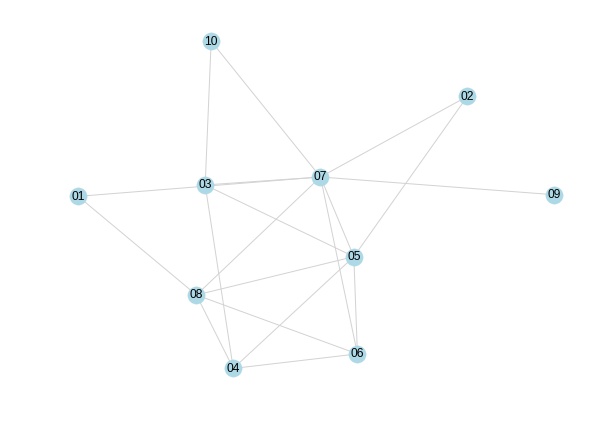

In [32]:
g = nx.from_dict_of_lists(dct)
# nx.draw(g, node_color='lightblue', with_labels=True)
nx.draw(g, node_color='lightblue', edge_color='lightgray', labels={k: k[-2:] for k in g.nodes()}) 

In [25]:
{n: g.neighbors(n) for n in g.nodes_iter()} 

{'u0001': ['u0007', 'u0008'],
 'u0002': ['u0007', 'u0005'],
 'u0003': ['u0010', 'u0007', 'u0004', 'u0005'],
 'u0004': ['u0003', 'u0006', 'u0008', 'u0005'],
 'u0005': ['u0003', 'u0007', 'u0006', 'u0008', 'u0002', 'u0004'],
 'u0006': ['u0004', 'u0007', 'u0008', 'u0005'],
 'u0007': ['u0010',
  'u0003',
  'u0006',
  'u0008',
  'u0001',
  'u0009',
  'u0002',
  'u0005'],
 'u0008': ['u0001', 'u0004', 'u0007', 'u0006', 'u0005'],
 'u0009': ['u0007'],
 'u0010': ['u0003', 'u0007']}

In [26]:
list(nx.algorithms.clique.find_cliques_recursive(g)) 

[['u0007', 'u0010', 'u0003'],
 ['u0007', 'u0009'],
 ['u0007', 'u0001', 'u0008'],
 ['u0007', 'u0005', 'u0003'],
 ['u0007', 'u0005', 'u0006', 'u0008'],
 ['u0007', 'u0005', 'u0002'],
 ['u0004', 'u0005', 'u0003'],
 ['u0004', 'u0005', 'u0006', 'u0008']]

In [27]:
set(filter(lambda x: len(x) > 2, map(lambda x: tuple(sorted(x)), nx.algorithms.clique.find_cliques_recursive(g)))) 

{('u0001', 'u0007', 'u0008'),
 ('u0002', 'u0005', 'u0007'),
 ('u0003', 'u0004', 'u0005'),
 ('u0003', 'u0005', 'u0007'),
 ('u0003', 'u0007', 'u0010'),
 ('u0004', 'u0005', 'u0006', 'u0008'),
 ('u0005', 'u0006', 'u0007', 'u0008')}

In [28]:
g.add_edge('u0002', 'u0004')
g.add_edge('u0005', 'u0001')
set(filter(lambda x: len(x) > 2, map(lambda x: tuple(sorted(x)), nx.algorithms.clique.find_cliques_recursive(g)))) 

{('u0001', 'u0005', 'u0007', 'u0008'),
 ('u0002', 'u0004', 'u0005'),
 ('u0002', 'u0005', 'u0007'),
 ('u0003', 'u0004', 'u0005'),
 ('u0003', 'u0005', 'u0007'),
 ('u0003', 'u0007', 'u0010'),
 ('u0004', 'u0005', 'u0006', 'u0008'),
 ('u0005', 'u0006', 'u0007', 'u0008')}

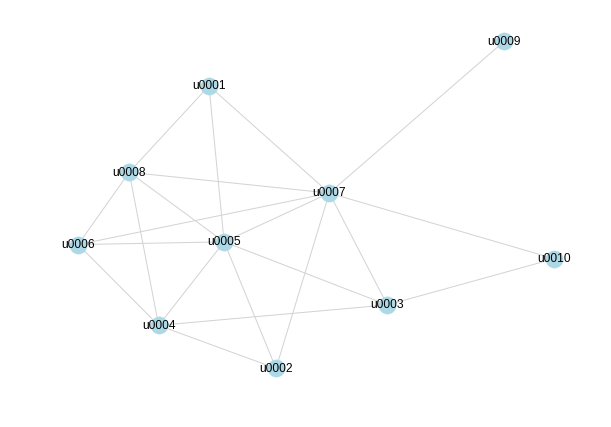

In [29]:
nx.draw(g, with_labels=True, node_color='lightblue', edge_color='lightgrey')